In [2]:
# main libraries
import numpy as np
import pandas as pd
from scipy import stats
from collections import Counter
from operator import itemgetter
import heapq

# NLP
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# NLTK Stop words
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('punkt')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
print(len(stop_words))
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'ibm', 'need', 'end', 
                   'time', 'i', 'me', 'my', 'myself', 'we', 'our', 
                   'ours', 'ourselves', 'you', "you're", "you've",
                   "you'll", "you'd", 'your', 'yours', 'yourself',
                   'yourselves', 'he', 'him', 'his', 'himself', 'she',
                   "she's", 'her', 'hers', 'herself', 'it', "it's", 'its',
                   'itself', 'they', 'them', 'their', 'theirs', 'themselves',
                   'what', 'which', 'who', 'whom', 'this', 'that', "that'll",
                   'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be',
                   'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
                   'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or',
                   'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for',
                   'with', 'about', 'against', 'between', 'into', 'through',
                   'during', 'before', 'after', 'above', 'below', 'to', 'from',
                   'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under',
                   'again', 'further','IBaMèo', 'then', 'once', 'here', 'there', 'when', 
                   'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few',
                   'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not','only', 
                   'own', 'same', 'so', 'than', 'too', 'very', 's', 't',
                   'can', 'will', 'just', 'don', "don't", 'should', "should've",
                   'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren',
                   "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn',
                   "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven',
                   "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't",
                   'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't",
                   'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't",
                   'won', "won't", 'wouldn', "wouldn't", 'has', 'ha'])

print(len(stop_words))

# Plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning);
warnings.simplefilter('ignore')

# view line by line of code
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

179
370


In [3]:
# Import DataFrame
df = pd.read_csv('RemediationData2020.csv', encoding='latin-1')
# df.head(2)

print("There are {} observations and {} features in this dataset. \n".format(df.shape[0],df.shape[1]))

There are 138 observations and 7 features in this dataset. 



In [4]:
# changing column name for easy access
df = df.rename(columns={'milestoneDescription':'finding'})
df.drop(columns=['supplier','createDate', 'source', 
                 'milestoneId', 'businessImpact', 'remediation'], inplace=True)
df.columns

Index(['finding'], dtype='object')

In [5]:
# Obtain Dataframe details and basic analysis

print('dataframe dimension:', df.ndim, '\ndatafram shape:', df.shape, '\ndataframe size:', df.size)
print('--------------------------')
print('--------------------------')
df.info()
print('--------------------------')
print('--------------------------')
print(df.isnull().sum())

dataframe dimension: 2 
datafram shape: (138, 1) 
dataframe size: 138
--------------------------
--------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138 entries, 0 to 137
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   finding  138 non-null    object
dtypes: object(1)
memory usage: 1.2+ KB
--------------------------
--------------------------
finding    0
dtype: int64


In [6]:
#replacing null value rows with string
#df['businessImpact'] = df['businessImpact'].fillna(0)
#df['businessImpact'] = df['businessImpact'].replace(to_replace = 0, value='Not Categorized')

#df['remediation'] = df['remediation'].fillna(0)
#df['remediation'] = df['remediation'].replace(to_replace = 0, value='Not Categorized')

#df.info()
#df.isnull().sum()

In [7]:
# =============================================================================
# Clean data Functions
# =============================================================================
def clean_normalize(text, lemma = True):
    text = re.sub(r'[^\s]*\.(com|org|net)\S*', '', text)#removing all website urls
    text = re.sub("(<.*?>)","",text)                    #remove html markup 
    text = re.sub(r'\d+', '', text)                     #removing numbers
    text = re.sub(r'\W', ' ', text)                     #remove all special characters
    text = re.sub(r'^\w\s', '', text)                   #removing punctuation and whitespace
    text = re.sub(r'\s+', ' ', text, flags=re.I)        #subing multiple spaces with one
    text = re.sub(r'(.)\1{2,}', '', text)               #removing repeated sequences more than 3
    text = text.lower()                                 #case normalization
    text = word_tokenize(text)                          #tokenize

    if lemma:
        # lemmatize word noun
        lem_word1 = [WordNetLemmatizer().lemmatize(word, pos='n') for word in text]
        #lemmatize word verb
        lem_word2 = [WordNetLemmatizer().lemmatize(word, pos='v') for word in lem_word1]
        #join words to form sentence
        new_sent = [word for word in lem_word2 if word not in stop_words]
            
    return new_sent

def least_common_values(array, to_find=None):
    '''
    Parameters
    ----------
    array :   Item count
    to_find : number of counts, optional
              DESCRIPTION. The default is None.

    Returns
    -------
    Least number of items in the list
    '''
    counter = Counter(array)
    if to_find is None:
        return sorted(counter.items(), key=itemgetter(1), reverse=False)
    return heapq.nsmallest(to_find, counter.items(), key=itemgetter(1))

# Removing all stop wrods
def remove_stop_words(column):
    mylist = []
    '''removing stop words from the list'''
    for token in column:
        if token not in stop_words:
            mylist.append(token)           
    return mylist

# Tokenizing column for word count frequency
def token_list(column):
    '''
    loop through the column
    extract tokens, second loop
    to extract stop words
        
    Parameter
    ---------
    df['column'] : specified column in data frame
        
    Return
    ---------
    list of tokens without stopwords
    '''
    all_tokens = []
    column_tokens = []
    for token in column: # Outer loop extending tokens to list
        column_tokens.extend(token)  # get all tokens from list
    for word in all_tokens:   # Nested loop efiltering stop words
        if word not in stop_words: #flilter condition
            column_tokens.append(word)

    return column_tokens

In [8]:
# =============================================================================
# Clean data
# =============================================================================
# unstructured text columns
print(df['finding'][3:8])
df['finding'] = df['finding'].apply(clean_normalize)
print(df['finding'][3:8])

3    Security posture of hosting datacenters must b...
4    Supplier has not deployed an Endpoint Detectio...
5    Supplier has not deployed an Infrastructure Sc...
6    Supplier has not deployed a Security Informati...
7        Disaster Recovery Plan has not been completed
Name: finding, dtype: object
3    [security, posture, host, datacenters, must, s...
4    [supplier, deploy, endpoint, detection, respon...
5    [supplier, deploy, infrastructure, scan, secur...
6    [supplier, deploy, security, information, even...
7                 [disaster, recovery, plan, complete]
Name: finding, dtype: object


In [9]:
# describing 3 categorical values of np.object (count, frequency, highest occurance)
df[['finding']]\
    .describe(include = np.object)\
    .transpose()

,count,unique,top,freq
finding,138,117,"[summary, action, security, test, supplier, co...",6


#### Frequency Distribution
1. Obtain single frequency count of all words in dataset
2. Plot distribution

In [10]:
# Tokenizing column for word count frequency
findings_token = token_list(df['finding'])
print(findings_token[1:30])

# counting frequency of words with counter
findings_token_counter = Counter(remove_stop_words(findings_token))
findings_token_counter.most_common(10) #most common
least_common_values(findings_token_counter, to_find = 10) #Least common

['provide', 'current', 'previous', 'penetration', 'test', 'write', 'summary', 'test', 'result', 'call', 'test', 'date', 'test', 'methodology', 'summary', 'find', 'remediation', 'plan', 'critical', 'high', 'medium', 'risk', 'find', 'dsr', 'service', 'system', 'integrity', 'availability', 'control']


[('test', 60),
 ('supplier', 42),
 ('penetration', 28),
 ('security', 28),
 ('report', 26),
 ('soc', 24),
 ('provide', 20),
 ('assessment', 18),
 ('type', 17),
 ('process', 16)]

[('ibamèo', 1),
 ('previous', 1),
 ('call', 1),
 ('dsr', 1),
 ('ass', 1),
 ('manual', 1),
 ('ethical', 1),
 ('hack', 1),
 ('thereafter', 1),
 ('enlist', 1)]

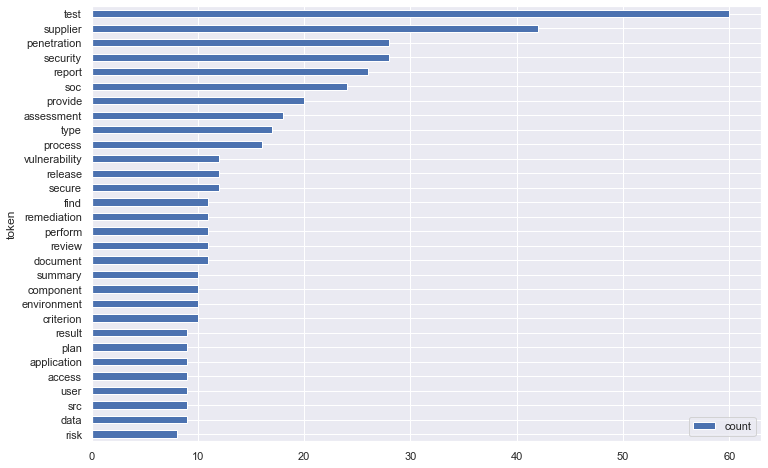

In [11]:
# visualizing Frequency Distribution
# most common
findings_token_df1 = pd.DataFrame.from_records(findings_token_counter.most_common(30),
                                        columns = ['token', 'count'])

# bar view of tokens
findings_token_df1.plot(kind = 'barh', x = 'token', figsize = (12, 8))\
                    .invert_yaxis()
plt.show()

#### Frequency DIstribution Bigrams
1. Obtain Bigram count
2. Plot count

In [12]:
#Create your bigrams
bgs = nltk.bigrams(findings_token)

#compute frequency distribution for all the bigrams in the text
fdist = nltk.FreqDist(bgs)

# manual view of the list
# for k,v in fdist.items():
#    print(k,v)

Bigram Distribution can reveal greater insight of major themes in the data

[(('penetration', 'test'), 28),
 (('soc', 'type'), 17),
 (('test', 'supplier'), 10),
 (('secure', 'release'), 10),
 (('security', 'test'), 9),
 (('release', 'criterion'), 9),
 (('supplier', 'component'), 8),
 (('component', 'accordance'), 8),
 (('accordance', 'secure'), 8),
 (('criterion', 'src'), 8)]

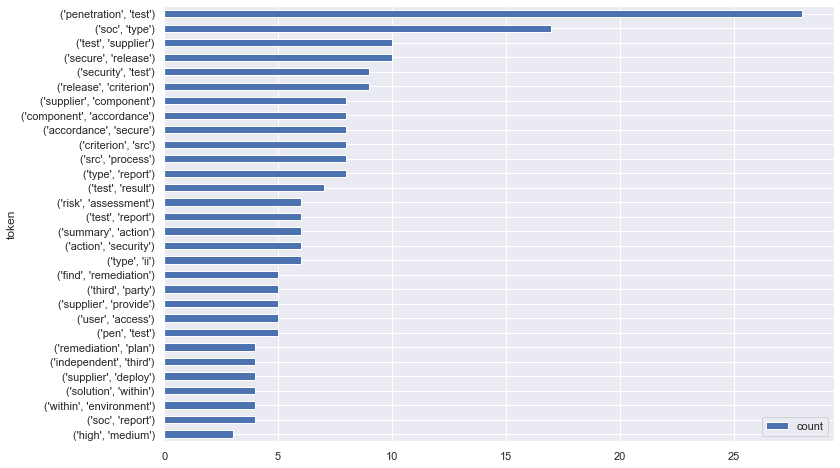

In [13]:
# counting frequency of words with counter
fdist.most_common(10) #most common

fdist_df1 = pd.DataFrame.from_records(fdist.most_common(30),
                                        columns = ['token', 'count'])

# bar view of tokens
fdist_df1['token'] = fdist_df1['token'].apply(str)
fdist_df1.plot(kind = 'barh', x = 'token', figsize = (12, 8))\
                    .invert_yaxis()
plt.show()

## Cluster Analysis using Document Embeddings
Analysis steps:
1. Embed documents using pre-trained glove model
2. Apply kmeans cluster algorithm
3. Analyze clusters to identify patterns within each cluster

In [14]:
# import Flair library
from flair.embeddings import WordEmbeddings, DocumentPoolEmbeddings
from flair.data import Sentence
import flair, torch

# since this is small dataset, can process this with cpu
flair.device = torch.device('cpu') 

# initialize the word embeddings
glove_embedding = WordEmbeddings('glove')

# initialize the document embeddings, mode = mean
document_embeddings = DocumentPoolEmbeddings([glove_embedding]);

In [15]:
# building function that for given column, it will iterate over each row and embed sentences
def doc_embedding(target_feature):
    sentence = Sentence(target_feature)
    # embed the sentence with our document embedding
    document_embeddings.embed(sentence)
    return sentence.embedding

# build new column and append to existing data frame
df['embedding'] = df.finding.apply(doc_embedding)

In [16]:
# obtain random row and view embedding results
df.head()

,finding,embedding
0,"[ibamèo, provide, current, previous, penetrati...","[tensor(-0.2100), tensor(0.1161), tensor(0.232..."
1,"[code, doe, support, byok]","[tensor(0.0828), tensor(0.3998), tensor(0.1009..."
2,"[independent, third, party, penetration, test,...","[tensor(-0.2241), tensor(0.0924), tensor(0.353..."
3,"[security, posture, host, datacenters, must, s...","[tensor(-0.2854), tensor(0.1502), tensor(0.252..."
4,"[supplier, deploy, endpoint, detection, respon...","[tensor(-0.3075), tensor(0.1568), tensor(0.454..."


In [17]:
# prepare dataset for cluster algorithm
from sklearn.cluster import KMeans

# conver tensor to array
x = df['embedding'].apply(np.array)
# np.stack removes nested arrays
X = np.stack(x.to_numpy())

#### Elbow Diagram
This plot will assist in identifying the optimal number of clusters to be used during the analysis. To find the optimal clusters, choose the value with the greatest decline in its inertia. in this case 6 cluster seems to be the best value as there is a measurable drop in inertial, from 6 to 19 there is a linear relation and drops in inertial are at small increments.

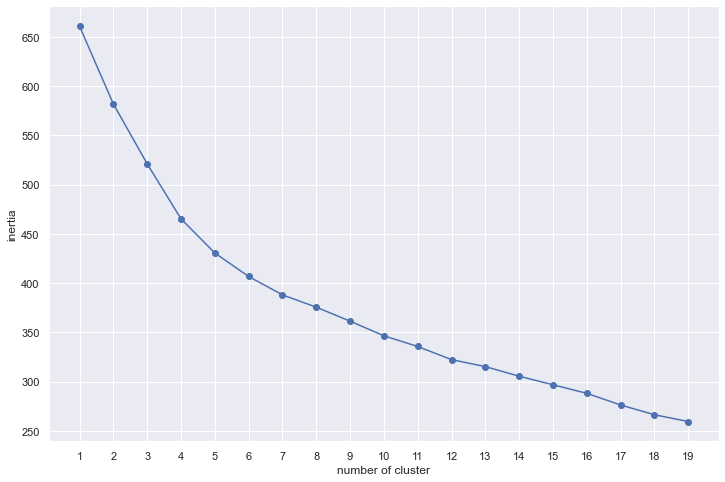

In [18]:
# obtain inertia value for optimal cluster number
cluster_range = range(1, 20)
inertia = []

for i in cluster_range:
    kmeans = KMeans(n_clusters = i, random_state = 0)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(12, 8))
plt.plot(cluster_range, inertia, '-o')
plt.xlabel('number of cluster')
plt.ylabel('inertia')
plt.xticks(cluster_range)
plt.show();

In [19]:
# initiate K-Means Model and fit to dataset
kmeans = KMeans(init='k-means++', n_clusters = 6, random_state = 0).fit(X)

# Obtain labels and assign to column
df['cluster_labels'] = kmeans.labels_

In [20]:
# obtain random row and view results
df.iloc[1:2,:]

,finding,embedding,cluster_labels
1,"[code, doe, support, byok]","[tensor(0.0828), tensor(0.3998), tensor(0.1009...",4


In [21]:
# view group count of each label
df.groupby(['cluster_labels']).count()

,finding,embedding
cluster_labels,,
0,5,5
1,14,14
2,26,26
3,7,7
4,70,70
5,16,16


In [22]:
# view all samples under cluster 1
df[df['cluster_labels'] == 1]

,finding,embedding,cluster_labels
7,"[disaster, recovery, plan, complete]","[tensor(-0.2242), tensor(0.4222), tensor(0.209...",1
17,"[conduct, provide, annual, risk, assessment, r...","[tensor(-0.3199), tensor(0.0483), tensor(0.169...",1
33,"[incident, response, policy, procedure, formal...","[tensor(-0.1303), tensor(-0.3109), tensor(0.05...",1
40,"[lack, document, organizational, security, pol...","[tensor(-0.1566), tensor(-0.2919), tensor(0.29...",1
49,"[sdlc, policy]","[tensor(0.1181), tensor(-0.1579), tensor(0.019...",1
56,"[disaster, recovery, plan]","[tensor(-0.2216), tensor(0.5143), tensor(0.189...",1
59,"[lack, organizational, security, policy, guide...","[tensor(-0.1334), tensor(-0.3310), tensor(0.27...",1
62,"[infrastructure, vulnerability, management, im...","[tensor(-0.3143), tensor(0.1142), tensor(0.118...",1
71,"[pentest, remediation, plan]","[tensor(-0.2424), tensor(0.3590), tensor(-0.28...",1
81,"[data, retention, disposal, policy, define, do...","[tensor(-0.1616), tensor(0.0957), tensor(0.272...",1


In [23]:
# Use PCA to remove co-linear feature and decrease feature redundancy
# Checks feature space and reduce dimension but keeps the information of all data 
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(X)
transformed = pca.transform(X)
print(transformed.shape)

PCA(n_components=3)

(138, 3)


In [24]:
# Build Kmeans model using transformed data
#kmeans = KMeans(init='k-means++', n_clusters = 6, random_state = 0).fit(transformed)

# obtain labels
#df['pca_cluster'] = kmeans.labels_

# view groups
#df.groupby(['pca_cluster']).count()

# assign to column
#df[df['pca_cluster'] == 1]

PCA Transformed model provides a better spread and therefore, cluster will be better identified without too much overlap of data

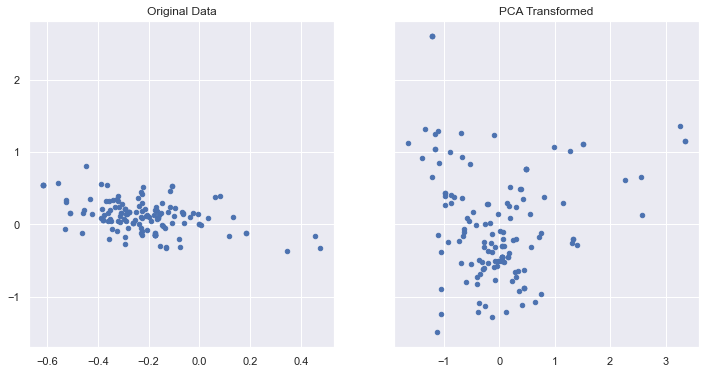

In [25]:
# compare data plots for cluster with and without pca transformation
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
ax1.scatter(X[:,0], X[:,1], s=20)
ax1.set_title('Original Data')
ax2.scatter(transformed[:,0], transformed[:,1], s=20)
ax2.set_title('PCA Transformed');

Finding Optimal Cluster Centers using Expectation-Maximization algorithm. For a better undrestanding, refer to Python Data Science Handbook found [here](https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html).

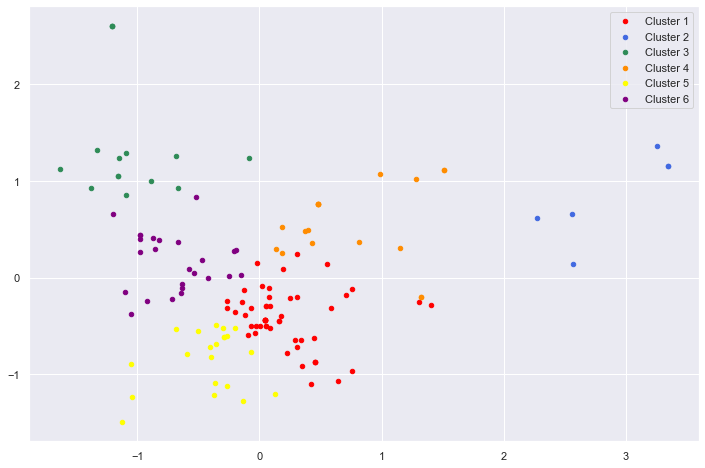

In [26]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(transformed, 6)

plt.figure(figsize=(12, 8))
plt.scatter(transformed[labels==0, 0], transformed[labels==0, 1], c='red', s=20, label ='Cluster 1')
plt.scatter(transformed[labels==1, 0], transformed[labels==1, 1], c='royalblue', s=20, label ='Cluster 2')
plt.scatter(transformed[labels==2, 0], transformed[labels==2, 1], c='seagreen', s=20, label ='Cluster 3')
plt.scatter(transformed[labels==3, 0], transformed[labels==3, 1], c='darkorange', s=20, label ='Cluster 4')
plt.scatter(transformed[labels==4, 0], transformed[labels==4, 1], c='yellow', s=20, label ='Cluster 5')
plt.scatter(transformed[labels==5, 0], transformed[labels==5, 1], c='purple', s=20, label ='Cluster 6')
plt.legend();

#centers = kmeans.cluster_centers_
#plt.scatter(centers[:, 0], centers[:, 1], marker='X', c='black', s=80, alpha=0.6);

In [27]:
# add labels to dataframe and review groups
df['pca_cluster'] = labels
df.groupby(['pca_cluster']).count()

,finding,embedding,cluster_labels
pca_cluster,,,
0,53,53,53
1,6,6,6
2,15,15,15
3,18,18,18
4,21,21,21
5,25,25,25


### 3D Plot
This plot helps identifying data overlap, you can visually see the extent of cluster with overlaping data

In [28]:
import plotly
import plotly.graph_objs as go

# Visualize cluster shapes in 3d.

cluster1= transformed[labels==0]
supplier1 = df[labels==0].supplier.to_numpy()

cluster2= transformed[labels==1]
cluster3= transformed[labels==2]
cluster4= transformed[labels==3]
cluster5= transformed[labels==4]
cluster6= transformed[labels==5]

scatter1 = dict(
    mode = "markers",
    name = "Cluster 1",
    type = "scatter3d",    
    x = cluster1[:,0], y = cluster1[:,1], z = cluster1[:,2],
    marker = dict( size=3, color='red'),
)
scatter2 = dict(
    mode = "markers",
    name = "Cluster 2",
    type = "scatter3d",    
    x = cluster2[:,0], y = cluster2[:,1], z = cluster2[:,2],
    marker = dict( size=3, color='royalblue')
)
scatter3 = dict(
    mode = "markers",
    name = "Cluster 3",
    type = "scatter3d",    
    x = cluster3[:,0], y = cluster3[:,1], z = cluster3[:,2],
    marker = dict( size=3, color='seagreen')
)
scatter4 = dict(
    mode = "markers",
    name = "Cluster 4",
    type = "scatter3d",    
    x = cluster4[:,0], y = cluster4[:,1], z = cluster4[:,2],
    marker = dict( size=3, color='darkorange')
)
scatter5 = dict(
    mode = "markers",
    name = "Cluster 5",
    type = "scatter3d",    
    x = cluster5[:,0], y = cluster5[:,1], z = cluster5[:,2],
    marker = dict( size=3, color='yellow')
)
scatter6 = dict(
    mode = "markers",
    name = "Cluster 6",
    type = "scatter3d",    
    x = cluster6[:,0], y = cluster6[:,1], z = cluster6[:,2],
    marker = dict( size=3, color='purple')
)
cluster1 = dict(
    alphahull = 5,
    name = "Cluster 1",
    opacity = .1,
    type = "mesh3d",    
    x = cluster1[:,0], y = cluster1[:,1], z = cluster1[:,2],
    color='red', showscale = True
)
cluster2 = dict(
    alphahull = 5,
    name = "Cluster 2",
    opacity = .1,
    type = "mesh3d",    
    x = cluster2[:,0], y = cluster2[:,1], z = cluster2[:,2],
    color='royalblue', showscale = True
)
cluster3 = dict(
    alphahull = 5,
    name = "Cluster 3",
    opacity = .1,
    type = "mesh3d",    
    x = cluster3[:,0], y = cluster3[:,1], z = cluster3[:,2],
    color='seagreen', showscale = True
)
cluster4 = dict(
    alphahull = 5,
    name = "Cluster 4",
    opacity = .1,
    type = "mesh3d",    
    x = cluster4[:,0], y = cluster4[:,1], z = cluster4[:,2],
    color='darkorange', showscale = True
)
cluster5 = dict(
    alphahull = 5,
    name = "Cluster 5",
    opacity = .1,
    type = "mesh3d",    
    x = cluster5[:,0], y = cluster5[:,1], z = cluster5[:,2],
    color='yellow', showscale = True
)
cluster6 = dict(
    alphahull = 5,
    name = "Cluster 6",
    opacity = .1,
    type = "mesh3d",    
    x = cluster6[:,0], y = cluster6[:,1], z = cluster6[:,2],
    color='purple', showscale = True
)
layout = dict(
    title = 'Interactive 3D Cluster',
    width=1000,
    height=1000,
    scene = dict(
        xaxis = dict( zeroline=True ),
        yaxis = dict( zeroline=True ),
        zaxis = dict( zeroline=True ),
    )
)
fig = dict(data=[scatter1, scatter2, scatter3, scatter4, scatter5, scatter6,
                 cluster1, cluster2, cluster3, cluster4, cluster5, cluster6], layout=layout)
# Use py.iplot() for IPython notebook
plotly.offline.iplot(fig, filename='mesh3d_sample')

AttributeError: 'DataFrame' object has no attribute 'supplier'

### Visualizing Cluster data
Lets do a frequency count of each cluster output, the plots will show frequency distribution, the goal is to identify themes within each cluster.

In [ ]:
# cluster list
clust = list(range(0, 6))

for i in clust:
    # first cluster
    cluster1 = df[df['pca_cluster'] == i]

    findings_token = token_list(cluster1['finding'])
    print(findings_token[0:10])

    #Create your bigrams
    bigrams = nltk.bigrams(findings_token)

    fdist = nltk.FreqDist(bigrams)

    # counting frequency of words with counter
    fdist.most_common(10) #most common
    fdist_df1 = pd.DataFrame.from_records(fdist.most_common(10),
                                            columns = ['token', 'count'])

    # bar view of tokens
    fdist_df1['token'] = fdist_df1['token'].apply(str)
    fdist_df1.plot(kind = 'barh', x = 'token', figsize = (12, 8))\
                        .invert_yaxis()
    plt.show();

#### VIsualizing Cluster Frequency Distribution without PCA Transformation.

In [ ]:
# cluster list
clust = list(range(0, 6))

for i in clust:
    # first cluster
    cluster1 = df[df['cluster_labels'] == i]

    findings_token = token_list(cluster1['finding'])
    print(findings_token[0:10])

    #Create your bigrams
    bigrams = nltk.bigrams(findings_token)

    fdist = nltk.FreqDist(bigrams)

    # counting frequency of words with counter
    fdist.most_common(10) #most common
    fdist_df1 = pd.DataFrame.from_records(fdist.most_common(10),
                                            columns = ['token', 'count'])

    # bar view of tokens
    fdist_df1['token'] = fdist_df1['token'].apply(str)
    fdist_df1.plot(kind = 'barh', x = 'token', figsize = (12, 8))\
                        .invert_yaxis()
    plt.show();